In [5]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy.signal import convolve2d
import cv2
from PIL import Image
from neural import Model

In [6]:
model = Model(folder_path="parameters", use_existing=True)

In [7]:
fn = "test_photos/ipad5mm3"
ext = ".jpg"

normal_size = (1200, 1200)
downscale_size = (600, 600)

im = Image.open(fn + ext)

im_resized = im.resize(downscale_size, Image.LANCZOS)
refined_img = im.resize(normal_size, Image.LANCZOS)
refined_img = np.asarray(refined_img)


In [8]:
def grayscale(img):
    r, g, b = 0.2989, 0.5870, 0.1140
    v = g * img[:, :, 0] + b * img[:, :, 1] + r * img[:, :, 2]
    v = 255 - v
    return np.uint8(v)

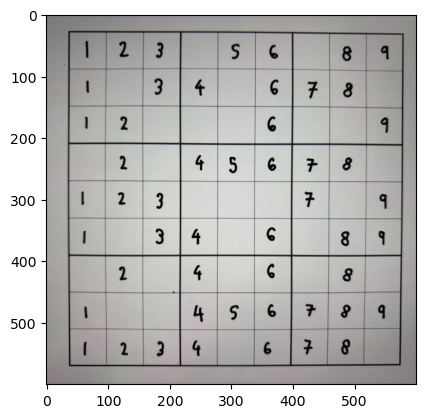

In [9]:
gray = np.asarray(im_resized)
# gray = grayscale(im_resized)

plt.imshow(gray, cmap="binary")

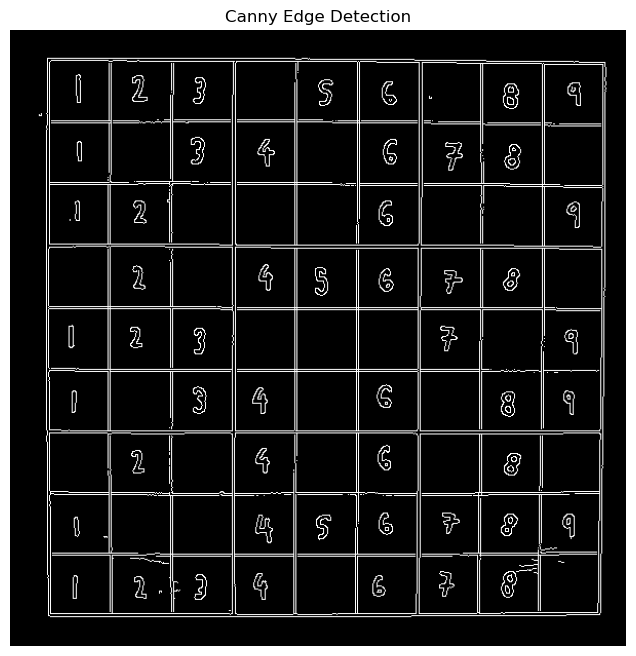

In [10]:
edges = cv2.Canny(gray, 50, 100) # Needs to impletement
# edges = np.where(gray < 127, 0, 255)

plt.figure(figsize=(8, 8))
plt.imshow(edges, cmap='gray')
plt.axis("off")
plt.title("Canny Edge Detection")
plt.show()

In [11]:
def img_to_1d_xy(img, ext):
    coords = np.argwhere(img != 0)  # Get nonzero (x, y) coordinates
    return coords

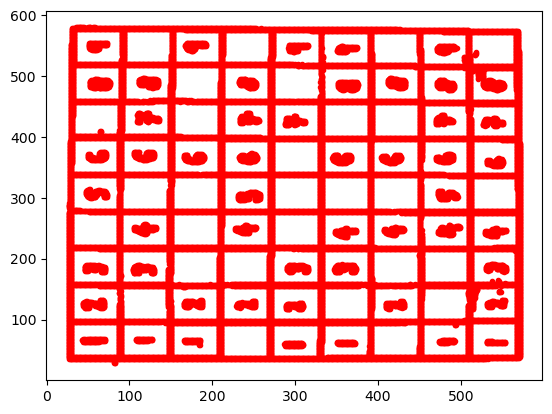

In [12]:
data = img_to_1d_xy(edges, ".jpg")
plt.plot(data[:,0], data[:,1], ".r")

In [13]:
def draw(r,theta,t_min=0,t_max=1000):
    x_0=np.array([r*np.cos(theta),r*np.sin(theta)])
    u=np.array([-np.sin(theta),np.cos(theta)])
    ts=np.linspace(t_min,t_max,100)
    xs=[]
    ys=[]
    for t in ts:
        x,y= x_0 + t*u
        if x < 0 or y < 0:
            x, y = x_0 - t*u
        xs.append(x)
        ys.append(y)
    plt.grid()
    plt.plot(xs, ys)

In [14]:
def get_hough_lines(data, bins=300, thr=300):
    rt = []
    for x, y in data:
        for theta in  np.linspace(0, np.pi, 100):
            r = x*np.cos(theta) + y *np.sin(theta)
            rt.append([r, theta])
    rt = np.array(rt)
    h, ex, ey, _ = plt.hist2d(rt[:,0], rt[:, 1], bins=bins);

    mid_r = (ex[1:] + ex[:-1])/2
    mid_t = (ey[1:] + ey[:-1])/2
    peaks = []
    for ir, it in np.argwhere(h > thr):
        peaks.append((mid_r[ir], mid_t[it]))

    return peaks

In [15]:
def get_closest(r1, t1, r2, t2): # get the smallest distance of two line given an interval
    l = np.linspace(0, 600, 100)

    x1 = r1 * np.cos(t1) + l * np.sin(t1)
    y1 = r1 * np.sin(t1) - l * np.cos(t1)

    x2 = r2 * np.cos(t2) + l * np.sin(t2)
    y2 = r2 * np.sin(t2) - l * np.cos(t2)

    distances = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

    return np.min(distances)

In [16]:
def group_and_filter_hough_lines(hough_lines, thr_r):

    horizontal_lines = []
    vertical_lines = []

    #Separate lines into horizontal & vertical groups
    for r, theta in hough_lines:
        if abs(theta - np.pi) < np.deg2rad(5):
            horizontal_lines.append((r, theta))
        elif abs(theta - np.pi / 2) < np.deg2rad(5):
            vertical_lines.append((r, theta))  # Near 90 degrees

    horizontal_lines.sort()
    vertical_lines.sort()

    # Step 3: Remove redundant lines
    def filter_parallel_lines(lines):
        if not lines:
            return []

        lines.sort()  # Sort by r
        filtered = [lines[0]]  # Start with the first line

        for i in range(1, len(lines)):
            r1, t1 = filtered[-1]
            r2, t2 = lines[i]

            min_dist = get_closest(r1, t1, r2, t2)

            if min_dist > thr_r:
                filtered.append((r2, t2))  # Keep only if sufficiently spaced

        return filtered

    return filter_parallel_lines(horizontal_lines), filter_parallel_lines(vertical_lines)

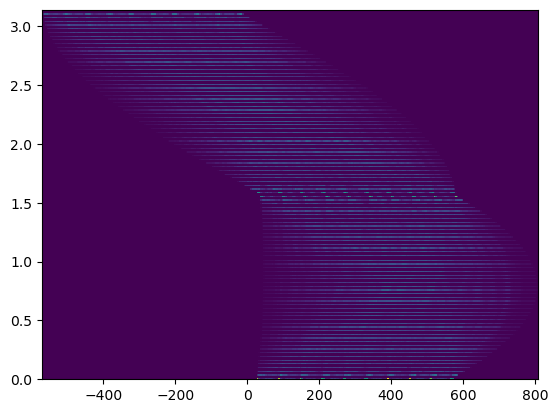

In [17]:
peaks = get_hough_lines(data, thr=400)
hor, ver = group_and_filter_hough_lines(peaks, 50)

-568.7012905575393 3.13635666583381
-508.9348450535636 3.13635666583381
-453.765818434509 3.13635666583381
-393.99937293053324 3.13635666583381
-334.23292742655747 3.13635666583381
-269.86906303766045 3.13635666583381
-210.1026175336847 3.13635666583381
-150.33617202970893 3.13635666583381
-90.56972652573316 3.13635666583381
-30.803281021757414 3.13635666583381
28.963164482218417 1.5865042900628454
88.72960998619419 1.5865042900628454
148.49605549016997 1.5865042900628454
212.85991987906692 1.5865042900628454
272.62636538304275 1.5865042900628454
332.3928108870185 1.5865042900628454
392.1592563909943 1.5865042900628454
451.9257018949701 1.5865042900628454
511.69214739894585 1.5865042900628454
580.6534306727641 1.5550883635269477


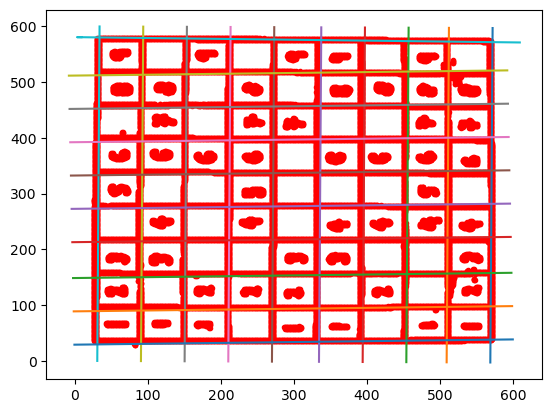

In [18]:
plt.plot(data[:, 0], data[:,1], '.r')
for r, t in hor:
    print(r, t)
    draw(r, t,0,600);
for r, t in ver:
    print(r,t)
    draw(r, t, 0,600);

In [19]:
def get_boxes(hor, ver):

    h_points = [[]] # the points where horizontal and vertical meets

    for r1, t1 in ver:
        for r2, t2 in hor:
            A = np.array([
                [np.cos(t1), np.sin(t1)],
                [np.cos(t2), np.sin(t2)]
            ])
            B = np.array([r1, r2])
            x, y = np.linalg.solve(A, B)
            if len(h_points[-1]) == 10:
                h_points.append([(x,y)])
            else:
                h_points[-1].append((x, y))

    boxes = []
    for i in range(len(h_points) - 1):
        for j in range(len(h_points) - 1):
            p00 = h_points[i][j]
            p01 = h_points[i][j+1]
            p10 = h_points[i+1][j]
            p11 = h_points[i+1][j+1]
            boxes.append([p00, p01, p10, p11])

    boxes = np.array(boxes).astype(int)
    boxes = np.reshape(boxes, (9, 9, 4, 2))
    boxes = boxes[:, ::-1] # boxes are reversed vertically
    boxes = boxes.swapaxes(0, 1) # need to do transpose
    return boxes


In [20]:
def clean_img(img):
    new = np.copy(img)
    canny = np.where(img < 128, 0, 255).astype(np.uint8)
    r_i = np.any(canny == 0, axis=1)  # If all rows are dark then it is noise
    c_i = np.any(canny == 0, axis=0)

    new[np.where(r_i == False)[0], :] = 0  # remove the noise
    new[:, np.where(c_i == False)[0]] = 0
    return new

def resize_image(image, target_size=(20, 20)):
    if not np.any(image):
        return image

    img_array = np.array(image)

# Thresholding (assuming dark ink on white background)
    threshold = 100  # Adjust if needed
    binary_img = img_array > threshold  # Create a mask (True = foreground)

    # Find bounding box of the digit
    coords = np.argwhere(binary_img)
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)

    # Crop the digit
    cropped_digit = img_array[y_min:y_max+1, x_min:x_max+1]

    digit_pil = Image.fromarray(cropped_digit)
    digit_resized = digit_pil.resize((20, 20), Image.LANCZOS)

    # Convert back to array and visualize
    final_image = np.array(digit_resized)

    # final_image = np.array(final_image)

    new_image = np.zeros((28, 28), dtype=np.uint8)
    # new_image = new_image + 255
    x_offset = (28 - 20) // 2
    y_offset = (28 - 20) // 2
    new_image[y_offset:y_offset+20, x_offset:x_offset+20] = final_image
    normalized = new_image // 1
    return normalized


In [21]:
def draw_number_frames(boxes, img):
    data = np.zeros((9,9))
    for i in range(len(boxes)):
        for j in range(len(boxes[0])):
            box = np.array(boxes[i][j])
            x_min = 2 * np.min(box[: , 0]) + 15
            x_max = 2 * np.max(box[:, 0]) - 15
            y_min = 2 * np.min(box[: , 1]) + 15
            y_max = 2 * np.max(box[:, 1]) - 15

            current_frame = img[x_min : x_max, y_min: y_max]

            n = current_frame
            n = clean_img(current_frame)
            n_i = np.where(n < 160)
            n[n_i] = 0
            if not np.any(n) or np.sum(n) < 10000:
                print("empty")
                data[i][j] = -1
                continue

            n = resize_image(n)


            pred = model.predict_one(n.flatten())
            data[i][j] = pred[0]

            # row = n.flatten()
            # row = n.reshape(1, -1)
            # row = np.insert(row, 0, j+1)
            # row = row.reshape(1, -1)
            # with open("image.csv", "a") as f:
            #     np.savetxt(f, row, delimiter=",", fmt="%d")

            # with open("ipad_train.csv", "a") as f:
            #     np.savetxt(f, row, delimiter=",", fmt="%d")

            # plt.imshow(n, cmap="binary")
            # plt.show()
    return data


In [42]:
# plt.imshow(grayscale(refined_img))

In [22]:
boxes = get_boxes(hor, ver)
# new_img = np.where(new_img < 128, 0, 255).astype(np.uint8)
table = draw_number_frames(boxes, grayscale(refined_img))

empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty


In [53]:
table[table == 0] = 9
true = np.array([[i for i in range(1,10)] for _ in range(9)])

print(f"{np.sum(true == table)}/81")
print(table)

48/81
[[ 8.  2.  3. nan  5.  6. nan  8.  9.]
 [ 8. nan  3.  4. nan  6.  7.  8. nan]
 [ 1.  2. nan nan nan  6. nan nan  9.]
 [nan  2. nan  4.  5.  6.  7.  8. nan]
 [ 8.  2.  3. nan nan nan  7. nan  9.]
 [ 1. nan  3.  4. nan  6. nan  8.  9.]
 [nan  2. nan  4. nan  6. nan  8. nan]
 [ 8. nan nan  4.  5.  6.  7.  8.  9.]
 [ 1.  2.  3.  4. nan  6.  7.  8. nan]]
